In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(context='talk', color_codes=True, palette='deep', style='whitegrid',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False}) #font_scale=0.3,

Fold

In [5]:
from scipy.special import softmax

c_min = -1*(0.25)**2
c_max = 1
M = 0.75

class AttractorNetwork:
    def __init__(self, stored_states, initial_state):
        self.attractors = stored_states.copy()
        self.state = initial_state.copy()
        self.c = c_min
        
        self.N = len(self.state)
        self.temperature = 1/(2*self.N)
        
    def dynamics(self):
        # potential = self.attractors.T.dot(softmax((1/self.temperature)*(1/self.N)*self.attractors.dot(self.state)))
        m = (1/self.N)*self.attractors.dot(self.state)
        input = np.array([-1*(m[0] - M)**2 - self.c,
                          m[2] - m[1],
                          m[1] - m[2]
                          ])
        attraction = self.attractors.T.dot(softmax((1/self.temperature)*(input + m)))
        return attraction - self.state
    
    def update(self):
        self.state += self.dynamics()*0.01


Generate correlated variables X, Y (with correlation $\rho$) from two normally distributed random variable $S_1, S_2$:

$$
X = \mu_x + \sigma_x S_1 \\
Y = \mu_y + \sigma_y (\rho S_1 + \sqrt{1 - \rho^2} S_2)
$$



In [3]:
# Simulate random states with high correlation

# Choose a system size
N = 1000

# Choose P random states of size N to store
P = 3

# Create correlated attractors
rng = np.random.default_rng()
random_vars = rng.standard_normal(size=(P, N))
stored_states = np.empty((P, N))

mu_x = 0
mu_y = 0
sigma_x = 1
sigma_y = 1
rho = 0 # <- this is the correlation
S1 = random_vars[0]
X = mu_x + sigma_x * S1
stored_states[0] = X

for index, random in enumerate(random_vars):
    if index == 0:
        continue 

    S2 = random
    Y = mu_y + sigma_y * (rho*S1 + np.sqrt(1-rho**2)*S2)

    stored_states[index] = Y

In [105]:
data = order_params.reshape((3, 100*2000))

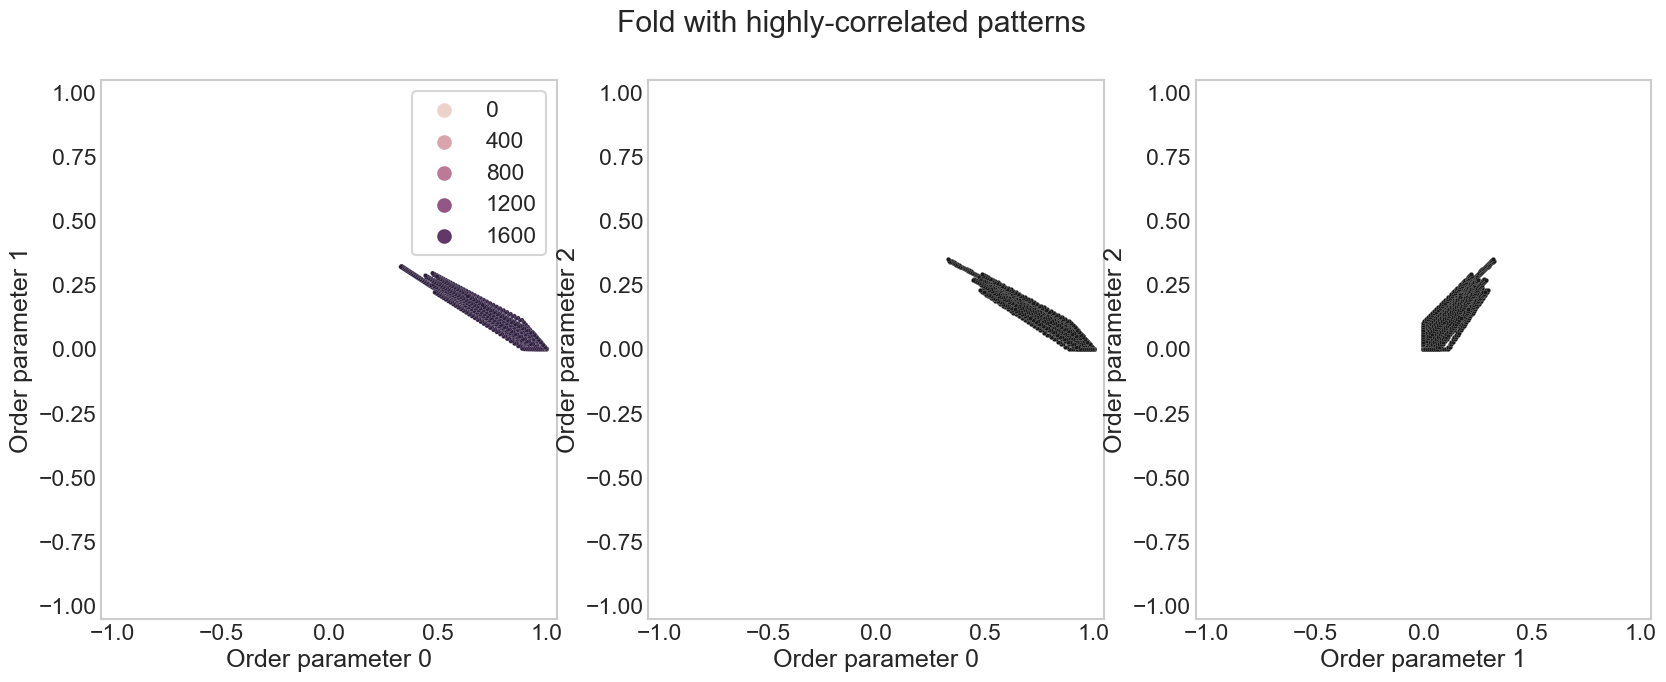

In [106]:
plt.figure(figsize=(20, 7))
nplots = 3

plt.suptitle('Fold with highly-correlated patterns')

plt.subplot(1, nplots, 1)
plt.xlabel('Order parameter 0')
plt.ylabel('Order parameter 1')
sns.scatterplot(x=data[0], y=data[1], hue=np.tile(range(2*N), 100), linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.subplot(1, nplots, 2)
plt.xlabel('Order parameter 0')
plt.ylabel('Order parameter 2')
sns.scatterplot(x=data[0], y=data[2], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.subplot(1, nplots, 3)
plt.xlabel('Order parameter 1')
plt.ylabel('Order parameter 2')
sns.scatterplot(x=data[1], y=data[2], color='k', linewidth=0.1, s=10)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.grid()

plt.show()

In [6]:
# Choose a system size
N = 1000

# Choose P random states of size N to store
P = 3

# Generate random states to store
# rng = np.random.default_rng()
# stored_states = rng.standard_normal(size=(P, N))
# stored_states = rng.choice([-1., 1.], size=(P,N))

# Choose a stored state as the initial state
initial_state = stored_states[0].copy()

# Add perturbations
initial_state += rng.normal(size=N, loc=0, scale=0.2)

# Choose a random state as the initial state
# initial_state = rng.standard_normal(size=N)
# initial_state = rng.choice([-1., 1.], size=(N))
# initial_state[:100] = stored_states[0, :100]

args = {'stored_states': stored_states,
        'initial_state': initial_state
        }

attractor_network = AttractorNetwork(**args)

total_time = 4*N # how many time steps to take
time = range(total_time)
magnetizations = np.empty((P, total_time))
cs = np.empty(total_time)
correlation_matrix = (1/N)*stored_states.dot(stored_states.T)
eta = (1/N)*np.linalg.inv(correlation_matrix).dot(stored_states)

for t in time:
    magnetizations[:, t] = (1/N)*attractor_network.attractors.dot(attractor_network.state).T
    cs[t] = attractor_network.c

    if (attractor_network.c < c_max) and t > (total_time/4):
        attractor_network.c += 0.001

    attractor_network.update()

order_params = np.linalg.inv(correlation_matrix).dot(magnetizations)

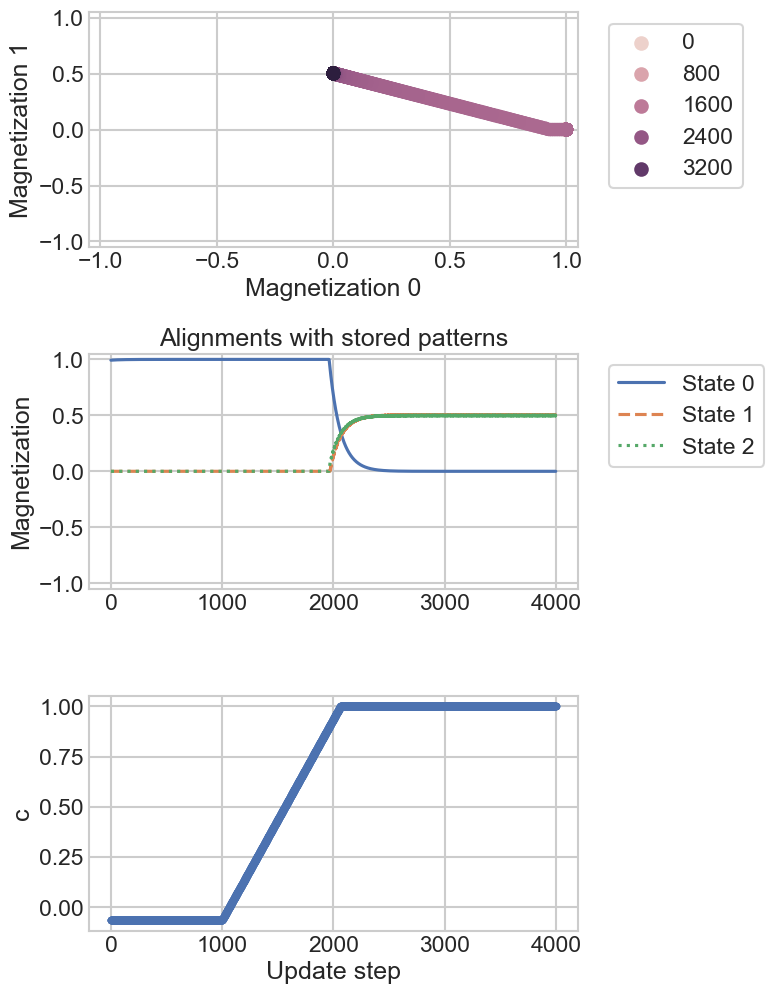

In [7]:
plt.figure(figsize=(8, 10))

xaxis = 0
yaxis = 1

data = order_params

plt.subplot(3, 1, 1)
plt.xlabel('Magnetization {}'.format(xaxis))
plt.ylabel('Magnetization {}'.format(yaxis))
sns.scatterplot(x=data[xaxis], y=data[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 2)
plt.title('Alignments with stored patterns')
# plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
linestyles = ['solid', 'dashed', 'dotted']
for i in range(P):
    plt.plot(time, data[i], linestyle=linestyles[i], label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 3)
plt.ylabel('c')
plt.plot(time, cs, '.')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

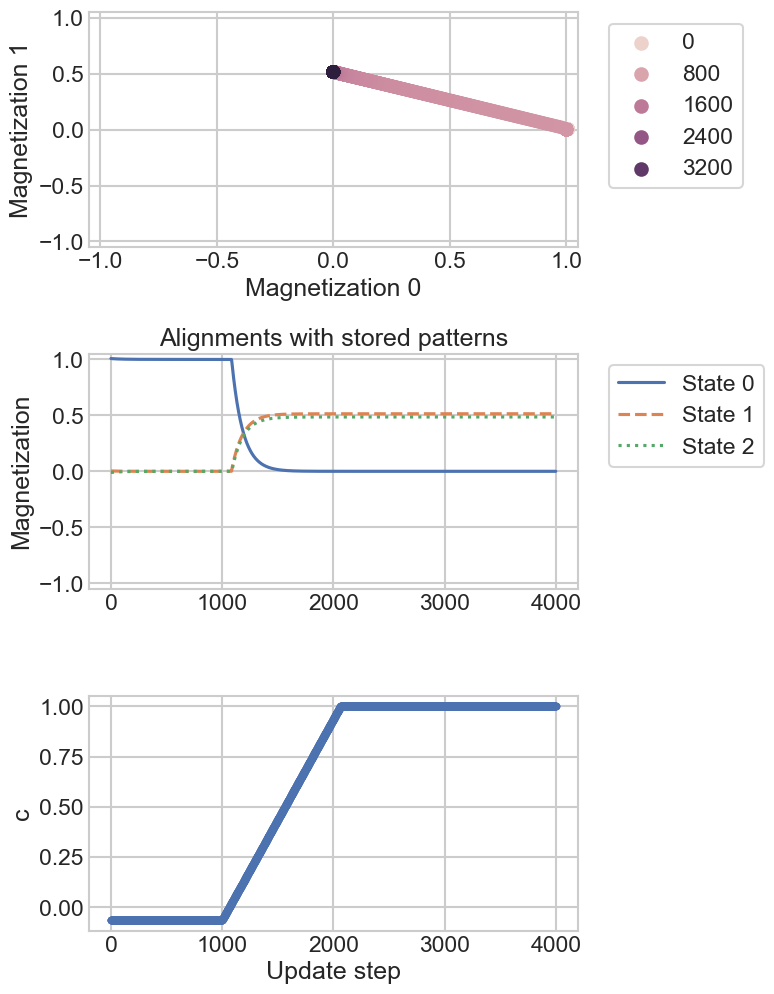

In [76]:
plt.figure(figsize=(8, 10))

xaxis = 0
yaxis = 1

data = order_params

plt.subplot(3, 1, 1)
plt.xlabel('Magnetization {}'.format(xaxis))
plt.ylabel('Magnetization {}'.format(yaxis))
sns.scatterplot(x=data[xaxis], y=data[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 2)
plt.title('Alignments with stored patterns')
# plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
linestyles = ['solid', 'dashed', 'dotted']
for i in range(P):
    plt.plot(time, data[i], linestyle=linestyles[i], label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 3)
plt.ylabel('c')
plt.plot(time, cs, '.')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

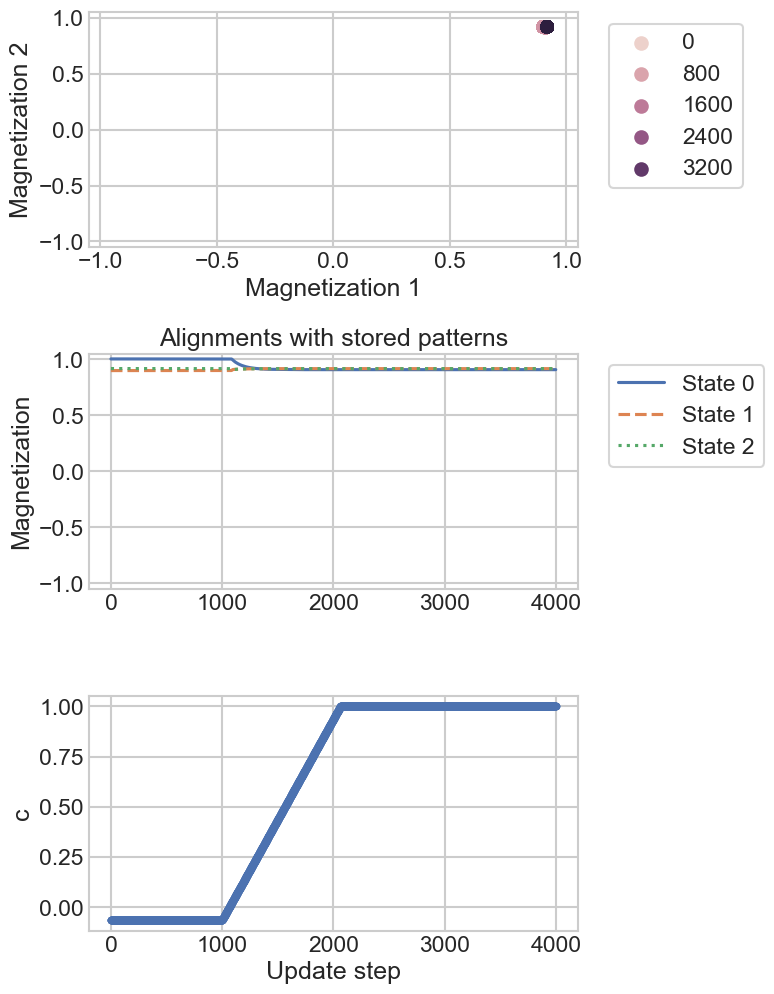

In [21]:
plt.figure(figsize=(8, 10))

xaxis = 1
yaxis = 2

plt.subplot(3, 1, 1)
plt.xlabel('Magnetization {}'.format(xaxis))
plt.ylabel('Magnetization {}'.format(yaxis))
sns.scatterplot(x=magnetizations[xaxis], y=magnetizations[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 2)
plt.title('Alignments with stored patterns')
# plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
linestyles = ['solid', 'dashed', 'dotted']
for i in range(P):
    plt.plot(time, magnetizations[i], linestyle=linestyles[i], label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 3)
plt.ylabel('c')
plt.plot(time, cs, '.')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

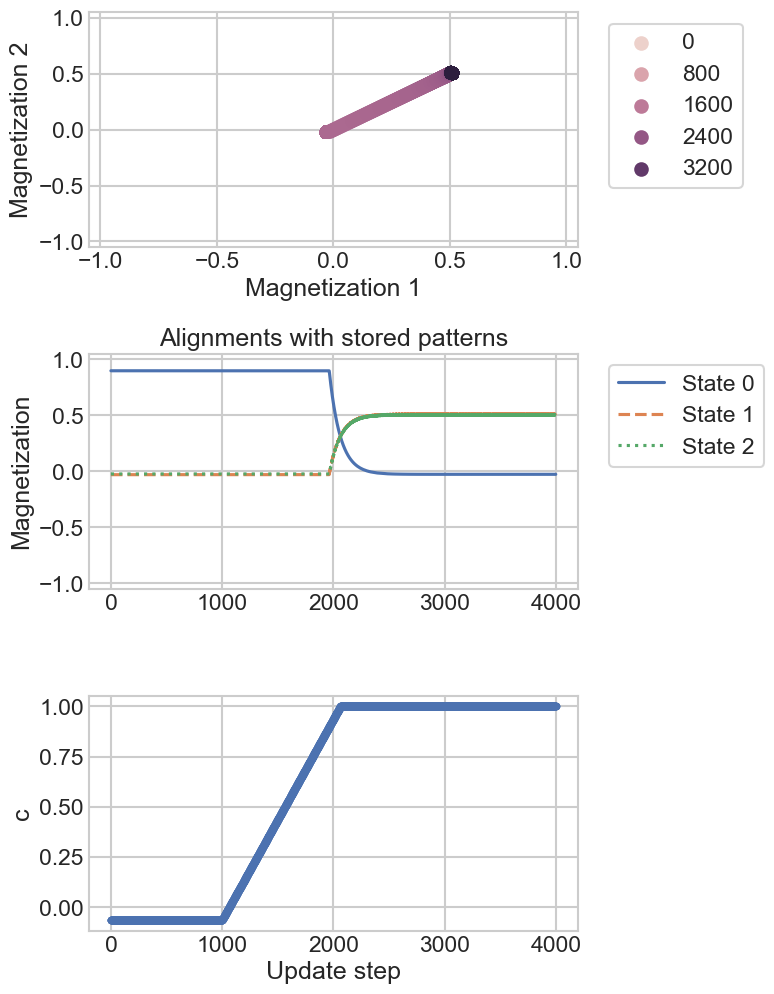

In [13]:
plt.figure(figsize=(8, 10))

xaxis = 1
yaxis = 2

plt.subplot(3, 1, 1)
plt.xlabel('Magnetization {}'.format(xaxis))
plt.ylabel('Magnetization {}'.format(yaxis))
sns.scatterplot(x=magnetizations[xaxis], y=magnetizations[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 2)
plt.title('Alignments with stored patterns')
# plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
linestyles = ['solid', 'dashed', 'dotted']
for i in range(P):
    plt.plot(time, magnetizations[i], linestyle=linestyles[i], label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 3)
plt.ylabel('c')
plt.plot(time, cs, '.')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

Cusp

In [220]:
from scipy.special import softmax

b_min = -6
b_max = 6
a = -2

class AttractorNetwork:
    def __init__(self, stored_states, initial_state):
        self.attractors = stored_states.copy()
        self.state = initial_state.copy()
        self.b = b_min
        
        self.N = len(self.state)
        self.temperature = 1/(2*self.N)
        
    def dynamics(self):
        # potential = self.attractors.T.dot(softmax((1/self.temperature)*(1/self.N)*self.attractors.dot(self.state)))
        m = (1/self.N)*self.attractors.dot(self.state)
        cusp_fn = 4*(m[2] - m[1])**3 + 2*a*(m[2] - m[1]) + self.b
        input = np.array([-1*m[0],
                          cusp_fn,
                          -1*cusp_fn
                          ])
        attraction = self.attractors.T.dot(softmax((1/self.temperature)*(input + m)))
        return attraction - self.state
    
    def update(self):
        self.state += self.dynamics()*0.01

In [225]:
# Choose a system size
N = 1000

# Choose P random states of size N to store
P = 3

# Generate random states to store
rng = np.random.default_rng()
stored_states = rng.standard_normal(size=(P, N))
# stored_states = rng.choice([-1., 1.], size=(P,N))

# Choose a stored state as the initial state
initial_state = stored_states[1]

# Choose a random state as the initial state
# initial_state = rng.standard_normal(size=N)
# initial_state = rng.choice([-1., 1.], size=(N))
# initial_state[:100] = stored_states[0, :100]

args = {'stored_states': stored_states,
        'initial_state': initial_state
        }

attractor_network = AttractorNetwork(**args)

total_time = N # how many time steps to take
time = range(total_time)
magnetizations = np.empty((P, total_time))
bs = np.empty(total_time)

for t in time:
    magnetizations[:, t] = (1/N)*attractor_network.attractors.dot(attractor_network.state)
    bs[t] = attractor_network.b

    if (attractor_network.b < b_max) and t > (total_time/8):
        attractor_network.b += 0.1

    attractor_network.update()

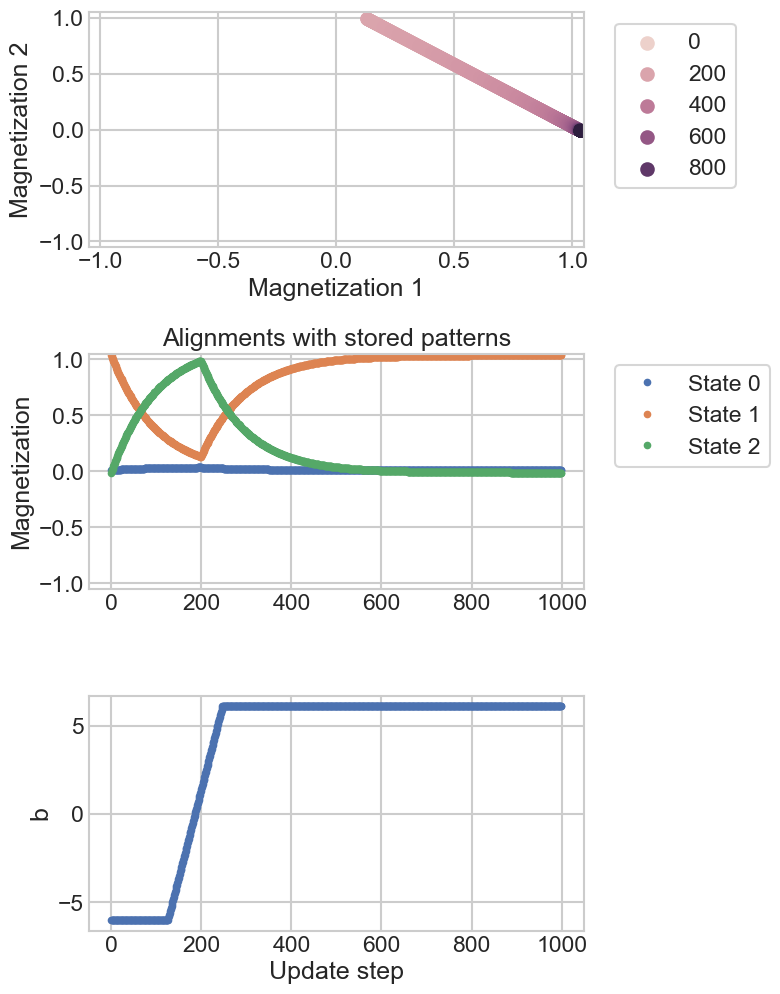

In [226]:
plt.figure(figsize=(8, 10))

xaxis = 1
yaxis = 2

plt.subplot(3, 1, 1)
plt.xlabel('Magnetization {}'.format(xaxis))
plt.ylabel('Magnetization {}'.format(yaxis))
sns.scatterplot(x=magnetizations[xaxis], y=magnetizations[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 2)
plt.title('Alignments with stored patterns')
# plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
for i in range(P):
    plt.plot(time, magnetizations[i], '.', label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 3)
plt.ylabel('b')
plt.plot(time, bs, '.')

plt.tight_layout()
plt.xlabel('Update step')
plt.show()

Fold + cusp

In [5]:
from scipy.special import softmax

b_min = -6
b_max = 6
a = -2

c_min = -(0.25)**2
c_max = 10
M = 0.75

class AttractorNetwork:
    def __init__(self, stored_states, initial_state):
        self.attractors = stored_states.copy()
        self.state = initial_state.copy()
        self.b = 0
        self.c = c_min
        
        self.N = len(self.state)
        self.temperature = 1/(2*self.N)
        
    def dynamics(self):
        # potential = self.attractors.T.dot(softmax((1/self.temperature)*(1/self.N)*self.attractors.dot(self.state)))
        m = (1/self.N)*self.attractors.dot(self.state)
        fn1 = 0
        fn2 = 0

        if m[0] <= 0.1:
             cusp_fn = 4*(m[2] - m[1])**3 + 2*a*(m[2] - m[1]) + self.b
             fn1 = cusp_fn
             fn2 = -1*cusp_fn

        if m[0] > 0.1:
             fn1 = m[2] - m[1]
             fn2 = m[1] - m[2]

        input = np.array([m[0]*(-1*(m[0] - M)**2 - self.c),
                          fn1,
                          fn2
                          ])

        attraction = self.attractors.T.dot(softmax((1/self.temperature)*(input + m)))
        return attraction - self.state
    
    def update(self):
        self.state += self.dynamics()*0.01

In [6]:
# Choose a system size
N = 1000

# Choose P random states of size N to store
P = 3

# Generate random states to store
rng = np.random.default_rng()
stored_states = rng.standard_normal(size=(P, N))
# stored_states = rng.choice([-1., 1.], size=(P,N))

# Choose a stored state as the initial state
initial_state = stored_states[0]

# Choose a random state as the initial state
# initial_state = rng.standard_normal(size=N)
# initial_state = rng.choice([-1., 1.], size=(N))
# initial_state[:100] = stored_states[0, :100]

args = {'stored_states': stored_states,
        'initial_state': initial_state
        }

attractor_network = AttractorNetwork(**args)

total_time = 2*N # how many time steps to take
time = range(total_time)
magnetizations = np.empty((P, total_time))
bs = np.empty(total_time)
cs = np.empty(total_time)

for t in time:
    magnetizations[:, t] = (1/N)*attractor_network.attractors.dot(attractor_network.state)
    bs[t] = attractor_network.b
    cs[t] = attractor_network.c

    if (attractor_network.c < c_max) and t > (total_time/4):
        attractor_network.c += 0.01
        
    if (attractor_network.b < b_max) and t > (total_time/2):
        attractor_network.b += 0.1

    attractor_network.update()

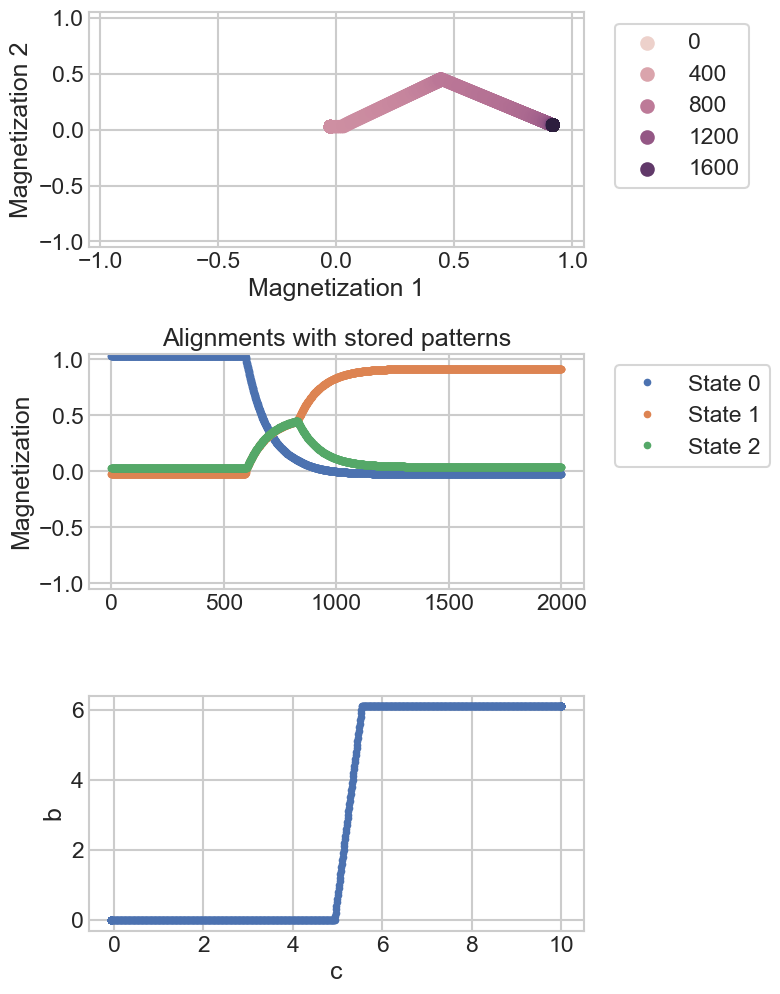

In [7]:
plt.figure(figsize=(8, 10))

xaxis = 1
yaxis = 2

plt.subplot(3, 1, 1)
plt.xlabel('Magnetization {}'.format(xaxis))
plt.ylabel('Magnetization {}'.format(yaxis))
sns.scatterplot(x=magnetizations[xaxis], y=magnetizations[yaxis], hue=time, edgecolor=None)
plt.xlim([-1.05,1.05])
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 2)
plt.title('Alignments with stored patterns')
# plt.title('Magnetizations (p = {})'.format(p))
plt.ylabel('Magnetization')
for i in range(P):
    plt.plot(time, magnetizations[i], '.', label="State {}".format(i))
plt.ylim([-1.05,1.05])
plt.legend(bbox_to_anchor=(1.04, 1.), loc='upper left')

plt.subplot(3, 1, 3)
plt.ylabel('b')
plt.plot(cs, bs, '.')

plt.tight_layout()
plt.xlabel('c')
plt.show()